In [1]:
import qutip
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List
import math
from IPython.display import clear_output


In [2]:
def generate_single_mapping(H_with_interaction_no_drive) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    OVERLAP_THRESHOLD = 0.01
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)

    total_dim = math.prod(dims)
    dressed_indices = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices[int(max_position)] = dressed_index
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    for product, dressed in zip(product_state_names,dressed_indices):
        product_to_dressed[product] = dressed
    return product_to_dressed

In [5]:
scqubits.GUI()

Container(children=[Sheet(children=[Card(children=[Img(layout=None, src='data:image/png;base64,iVBORw0KGgoAAAA…

In [3]:
EJ=8.9
EC=2.5
EL=0.5
g_strength = 0.3

qubit_level = 6
osc_level = 10

done:200/200


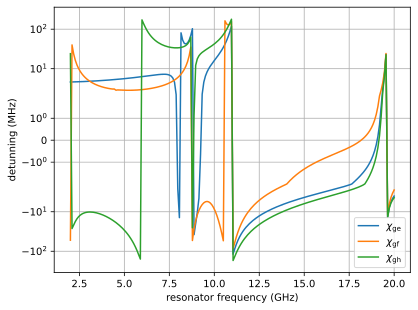

In [4]:
def dressed_transition_frequency_over_2pi(hilbertspace,s0, s1) -> float:
    return (hilbertspace.energy_by_dressed_index(s1) - hilbertspace.energy_by_dressed_index(s0))

def replace_non_float64_with_none(lst):
    for i in range(len(lst)):
        if type(lst[i]) is not np.float64:
            lst[i] = None
    return lst

def sweep_resonator_frequency_for_detunning(EJ=EJ,
                                        EC=EC,
                                        EL=EL,
                                        flux = 0):
    # for erasure detection, we want g0g1 detunned from e0e1 and f0f1
    # for measurement, we want one e0e1 detuned from the rest two.
    E_vals = np.linspace(2, 20, 200)
    g0g1_vals = []
    e0e1_vals = []
    f0f1_vals = []
    h0h1_vals = []

    qbt = scqubits.Fluxonium(
            EJ=EJ,
            EC=EC,
            EL=EL,
            flux=flux,
            cutoff=30,
            truncated_dim=qubit_level
        )
    num_done = 0
    num_tot = len(E_vals)
    for e in E_vals:
        osc = scqubits.Oscillator(
            E_osc=e,
            truncated_dim=20 # here I only use 20, but later use 50 in mesolve
        )
        hilbertspace = scqubits.HilbertSpace([qbt, osc])
        hilbertspace.add_interaction(
            g_strength=g_strength,
            op1=qbt.n_operator,
            op2=osc.creation_operator,
            add_hc=True
        )
        hilbertspace.generate_lookup()
        product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

        g0g1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(0,0)],product_to_dressed[(0,1)])
        e0e1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(1,0)],product_to_dressed[(1,1)])
        f0f1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(2,0)],product_to_dressed[(2,1)])
        h0h1 = dressed_transition_frequency_over_2pi(hilbertspace,product_to_dressed[(3,0)],product_to_dressed[(3,1)])

        g0g1_vals.append(g0g1)
        e0e1_vals.append(e0e1)
        f0f1_vals.append(f0f1)
        h0h1_vals.append(h0h1)
        g0g1_vals = replace_non_float64_with_none(g0g1_vals)
        e0e1_vals = replace_non_float64_with_none(e0e1_vals)
        f0f1_vals = replace_non_float64_with_none(f0f1_vals)
        h0h1_vals = replace_non_float64_with_none(h0h1_vals)
        num_done+=1
        if num_done%10 == 0:
            clear_output()
            print(f"done:{num_done}/{num_tot}")
    chi_ge_MHz = []
    for a, b in zip(e0e1_vals, g0g1_vals):
        if a is None or b is None:
            chi_ge_MHz.append(None)
        else:
            chi_ge_MHz.append((a - b)*1000)
    chi_gf_MHz = []
    for a, b in zip(f0f1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gf_MHz.append(None)
        else:
            chi_gf_MHz.append((a - b)*1000)
    chi_gh_MHz = []
    for a, b in zip(h0h1_vals, g0g1_vals):
        if a is None or b is None:
            chi_gh_MHz.append(None)
        else:
            chi_gh_MHz.append((a - b)*1000)
    plt.plot(E_vals, chi_ge_MHz, label=r'$\chi_{\mathrm{ge}}$')
    plt.plot(E_vals, chi_gf_MHz, label=r'$\chi_{\mathrm{gf}}$')
    plt.plot(E_vals, chi_gh_MHz, label=r'$\chi_{\mathrm{gh}}$')
    plt.yscale('symlog')
    plt.legend()
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    plt.xlabel("resonator frequency (GHz)")
    plt.ylabel("detunning (MHz)")
    plt.show()

sweep_resonator_frequency_for_detunning(EJ=EJ,
                                        EC=EC,
                                        EL=EL,
                                        flux = 0)

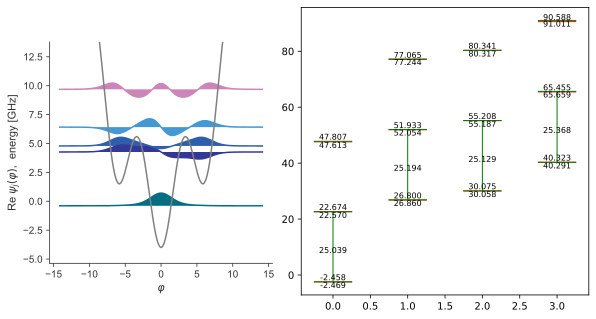

In [30]:
qbt = scqubits.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        flux=0,
        cutoff=30,
        truncated_dim=qubit_level
    )
osc = scqubits.Oscillator(
    # E_osc=qbt.eigenvals()[3]-qbt.eigenvals()[0]+0.05,
    E_osc = 4,
    truncated_dim=osc_level
)
hilbertspace = scqubits.HilbertSpace([qbt, osc])
hilbertspace.add_interaction(
    g_strength=g_strength,
    op1=qbt.n_operator,
    op2=osc.creation_operator,
    add_hc=True
)
hilbertspace.generate_lookup()
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

def plot_specturum(qubit, resonator, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]]):
    product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())
    energy_text_size = 8
    # clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = resonator.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = product_to_dressed[(ql,rl)]
            dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
            ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
            ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = product_to_dressed[(state1[0],state1[1])]
        dressed_index2 = product_to_dressed[(state2[0],state2[1])]
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()

plot_specturum(qbt, osc, hilbertspace)